In [26]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import BernoulliRBM
from skimage import measure
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
np.random.seed(0)

## Load both Chair and Airplane data, turn into arrays

In [13]:
# read chairs
train_dir = '/Users/yuxuanzhang/CSC529/3D_voxel_models/chair/'
train_names = [f for f in os.listdir(train_dir)]
train_names = train_names[1:] # get rid of .DS_Store file

chairs = []
for f in train_names:
    chairs.append(np.load(train_dir+f)) # load the binary array files
train_chairs = np.array(chairs)
train_chairs = train_chairs[:8000]
train_chairs=train_chairs.reshape([8000,32*32*32]) # turn train_chairs into 2D array [num of chairs, num of features]
train_chairs.shape

(8000, 32768)

In [15]:
# read airplane
train_dir = '/Users/yuxuanzhang/CSC529/3D_voxel_models/airplane/'
train_names = [f for f in os.listdir(train_dir)]
train_names = train_names[1:] # get rid of .DS_Store file

airplane = []
for f in train_names:
    airplane.append(np.load(train_dir+f)) # load the binary array files
train_airplane = np.array(airplane)
train_airplane = train_airplane[:8000]
train_airplane=train_airplane.reshape([8000,32*32*32]) # turn train_airplane into 2D array [num of airplane, num of features]
train_airplane.shape

(8000, 32768)

In [16]:
merged=np.vstack((train_chairs,train_airplane))

In [17]:
# shuffle
index = range(merged.shape[0])
random_generator = np.random.RandomState(1)
random_generator.shuffle(index)
x = merged[index]

In [18]:
x.shape

(16000, 32768)

### Train RBM

In [164]:
rbm = BernoulliRBM(n_components=1000, learning_rate=0.02, batch_size=200, n_iter=200, random_state=0, verbose=1)

In [165]:
rbm.fit(x)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -9663.75, time = 254.32s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -18960.92, time = 301.86s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -21831.42, time = 299.81s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -20318.21, time = 302.24s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -18555.23, time = 312.28s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -17285.58, time = 299.15s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -15533.53, time = 307.99s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -14376.06, time = 299.54s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -13282.20, time = 299.55s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -11983.13, time = 298.58s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -10732.10, time = 301.98s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -10156.70, time = 299.94s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -9382.60, time = 301.56s
[BernoulliRBM] Iteration 14, pseudo-

BernoulliRBM(batch_size=200, learning_rate=0.02, n_components=1000,
       n_iter=200, random_state=0, verbose=1)

In [145]:
rbm.components_.shape 

(1000, 32768)

### Save trained RBM model

In [166]:
import cPickle as pickle

In [168]:
with open('rbm.pickle', 'wb') as f:
    pickle.dump(rbm, f, pickle.HIGHEST_PROTOCOL)

### Read trained RBM model

In [169]:
with open('rbm.pickle', 'rb') as f:
        rbm111 = pickle.load(f)

In [170]:
rbm111.get_params

<bound method BernoulliRBM.get_params of BernoulliRBM(batch_size=200, learning_rate=0.02, n_components=1000,
       n_iter=200, random_state=0, verbose=1)>

### See which hidden neurons are activated given a certain input

In [584]:
# compute the hidden layer activation probabilities, P(h=1|v=X).
# that is, transform the original data so that each row is represented by the latent features
# for an instance, each of its latent feature has value between [0,1], 
# indicating how much the latent feature is activated when this instance is presented
x_latent=rbm.transform(x)
x_latent.shape

(16000, 1000)

In [608]:
x_latent[:5].shape

(5, 1000)

In [585]:
# compute the pseudo-likelihood of input instances
# returns the log of the logistic function of the difference
rbm.score_samples(x[4])

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


-1.5262838336913267

## Visualization

In [261]:
# this function turns an array into a mesh, then plot it out
def plot_3d(voxel_matrix):
    # Use marching cubes to obtain the surface mesh of these ellipsoids
    vertices, faces = measure.marching_cubes(voxel_matrix,0.5)

    # Create the mesh and save as STL
    obj = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            obj.vectors[i][j] = vertices[f[j],:]

    figure = pyplot.figure()
    axes = mplot3d.Axes3D(figure)

    # Load the STL files and add the vectors to the plot
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(obj.vectors))

    # Auto scale to the mesh size
    scale = obj.points.flatten(-1)
    axes.auto_scale_xyz(scale, scale, scale)

    # Show the plot to the screen
    pyplot.show()

### Save voxel model as STL file

In [628]:
def save_stl(voxel_matrix,file_name):
    # Use marching cubes to obtain the surface mesh of these ellipsoids
    # level is a float number between the min and max of chair
    # the lower the level is, the more detail of voxels are captured; the higher, the less noise in the volumetric model
    vertices, faces = measure.marching_cubes(voxel_matrix,level=0.5)

    # Create the mesh and save as STL
    obj = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            obj.vectors[i][j] = vertices[f[j],:]
            
    # Write the mesh to STL file 
    obj.save(file_name+'.stl')
    print 'done.'

### Plot latent component/ hidden neurons extracted by RBM
<p>Weights from input features to a hidden neuron correspond to one filter, since it is a mapping from the input (e.g. from an actual image) to the hidden neuron.</p>
<p>Each component is a non-linear transformation of all original features. The intensity of a pixel in the filter img indicates how much the orginal feature/pixel contributed to this component/filter img. White means positve weight, black means negative weight, grey means zero weight.</p>

In [1297]:
# get the activated hidden neurons for a certain input instance
# activation sorted in decreasing order
activated = zip(range(len(x_latent[3])),x_latent[3])
activated.sort(key=lambda x: x[1],reverse=True)
activated[:10] # show first 10 mostly activated neurons

[(105, 1.0),
 (115, 1.0),
 (126, 1.0),
 (150, 1.0),
 (175, 1.0),
 (283, 1.0),
 (292, 1.0),
 (293, 1.0),
 (338, 1.0),
 (398, 1.0)]

/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


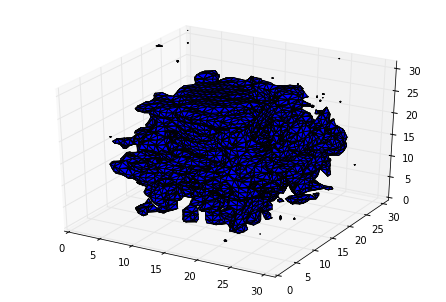

In [1197]:
latent = rbm.components_[175] # latent filter
latent = (latent - latent.min())/(latent.max()-latent.min()) # normalize between [0, 1]
voxel_matrix = latent.reshape([32,32,32]) 
plot_3d(voxel_matrix)

In [1198]:
# save voxel model as stl
latent = rbm.components_[175] # latent filter
latent = (latent - latent.min())/(latent.max()-latent.min()) # normalize between [0, 1]
voxel_matrix = latent.reshape([32,32,32]) 
save_stl(voxel_matrix,'filter')

done.


### Plot original voxel model

/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


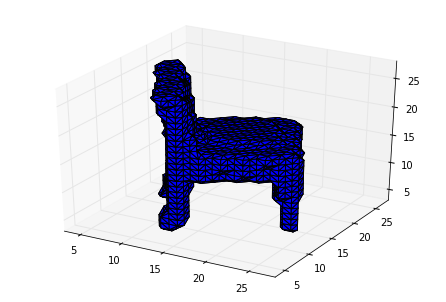

In [1307]:
voxel_matrix = x[4].reshape([32,32,32])
plot_3d(voxel_matrix)

In [1317]:
# save voxel model as stl
voxel_matrix = x[4].reshape([32,32,32])
save_stl(voxel_matrix,'original')

done.


###  Reconstruct original voxel model

In [658]:
# perform Gibbs sampling (Markov Chain Monte Carlo) for k steps
# start with values in visible layer, return values in visible layer after k Gibbs steps
# In general, the larger the k, the more normal-looking for the generated samples
def gibbs_sampling(k,x,rbm):
    counter = 0
    while counter < k:
        gibbs_x = rbm.gibbs(x) # return T/F which original pixels are activated
        x = np.zeros_like(x)
        x[gibbs_x] = 1 # make the "turned on" pixels to be 1, others to be 0
        counter+=1
    return x

In [1314]:
gen_x = gibbs_sampling(5,x[:10],rbm)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


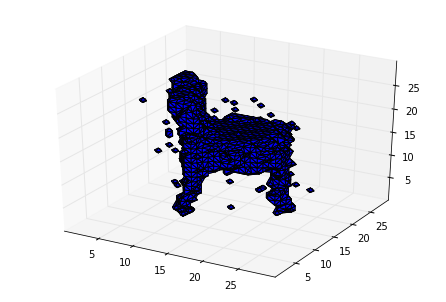

In [1315]:
reconstruct = gen_x[4] 
reconstruct = reconstruct.reshape([32,32,32]) 
plot_3d(reconstruct)

### Perform erosion and dilation to remove noise voxels

In [1056]:
from scipy import ndimage

eroded:


/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


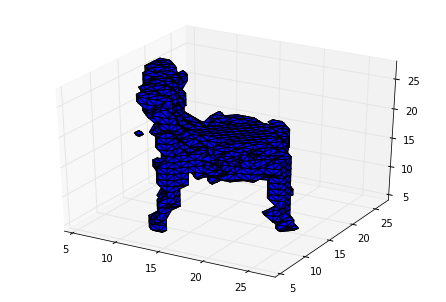

dilated:


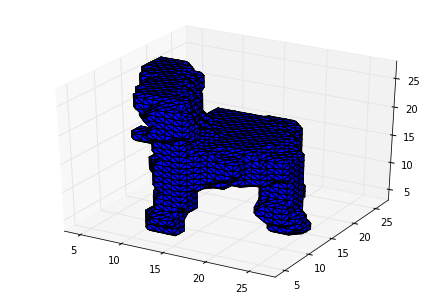

eroded again:


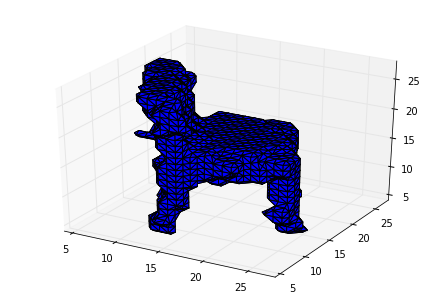

done.


In [1316]:
eroded=ndimage.binary_erosion(reconstruct,structure=np.ones((1,1,2))).astype(reconstruct.dtype)
print 'eroded:'
plot_3d(eroded)

dilated = ndimage.binary_dilation(eroded,structure=np.ones((3,2,2))).astype(eroded.dtype)
print 'dilated:'
plot_3d(dilated)

eroded=ndimage.binary_erosion(dilated,structure=np.ones((2,2,2))).astype(dilated.dtype)
print 'eroded again:'
plot_3d(eroded)

save_stl(eroded,'reconstruct')

### Generating new data in batch

In [278]:
# 10 random samples, each sample has 784 features between [0,1]
z = np.random.random_sample((10,32*32*32))

In [256]:
gen_z = gibbs_sampling(5000,z,rbm)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


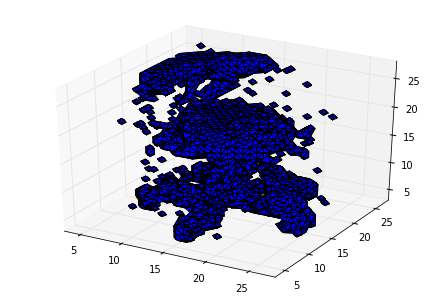

In [291]:
voxel_matrix = gen_z[7].reshape([32,32,32]) 
plot_3d(voxel_matrix)

### You can set the density of the random noise to control how large the generated voxel model is

In [988]:
### create a single random instance
z1 = np.zeros(32*32*32)
# the percentage of z1 to be 1, rest is 0
# 0.013: small chair
# 0.0125: small stool, hovering saucer
density = 0.0125

# randomly select density% elems to be 1
index = range(z1.shape[0])
random_generator = np.random.RandomState(1)
random_generator.shuffle(index)
selected_indices = index[:int(np.floor(z1.shape[0]*density))] 
z1[selected_indices] = 1

/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


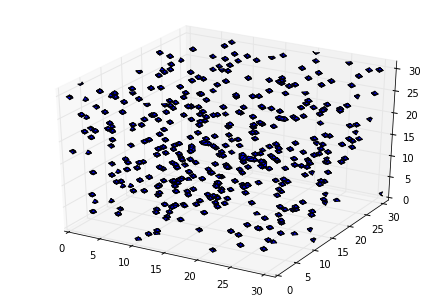

In [987]:
# when gibbs_sampling k=0, it returns the raw random noise
gen_z1 = gibbs_sampling(0,z1,rbm)

voxel_matrix = gen_z1.reshape([32,32,32]) 
plot_3d(voxel_matrix)

In [976]:
# save voxel model as stl
voxel_matrix = gen_z1.reshape([32,32,32]) 
save_stl(voxel_matrix,'generated')

done.


### As Gibbs samples from step 0 to N, show the resulting voxel model at each step 

generated model at step 0


/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


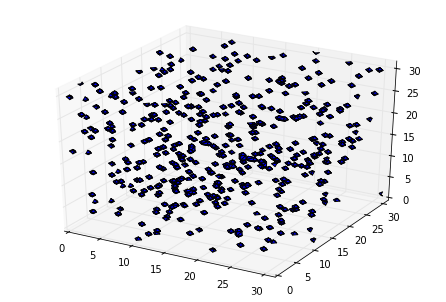

generated model at step 1


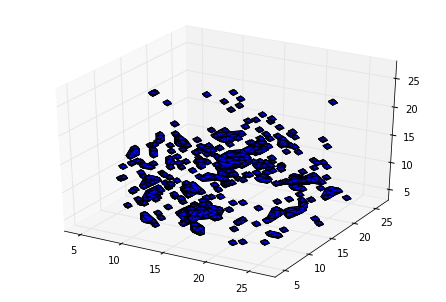

generated model at step 2


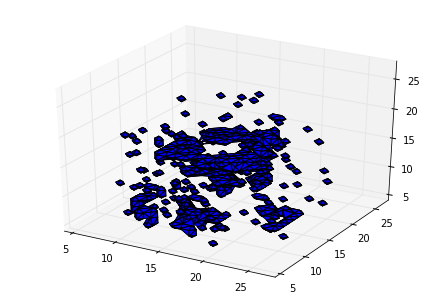

generated model at step 3


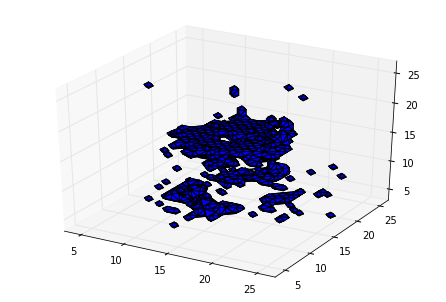

generated model at step 4


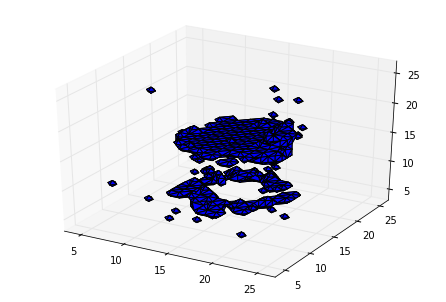

generated model at step 5


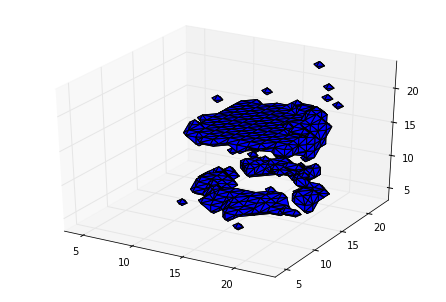

generated model at step 7


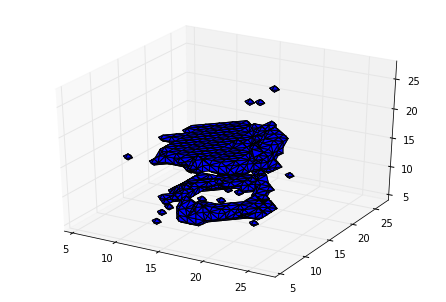

generated model at step 9


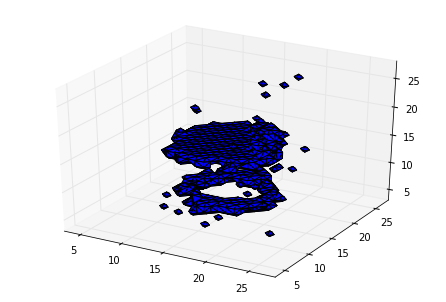

generated model at step 12


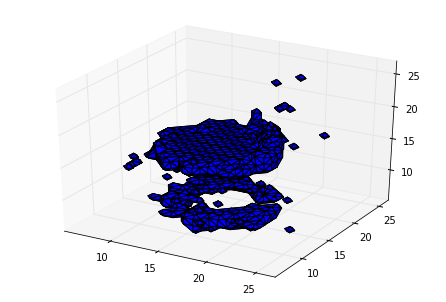

generated model at step 15


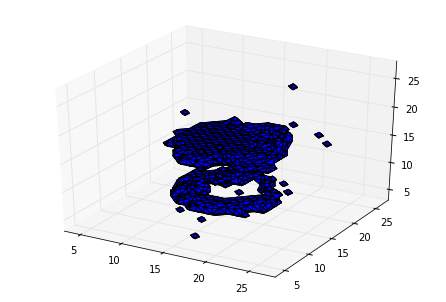

generated model at step 20


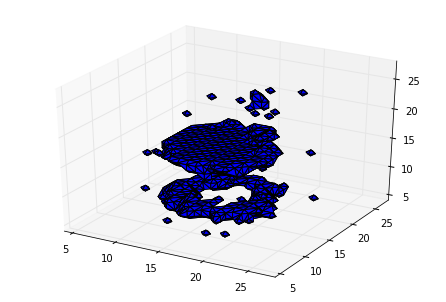

generated model at step 25


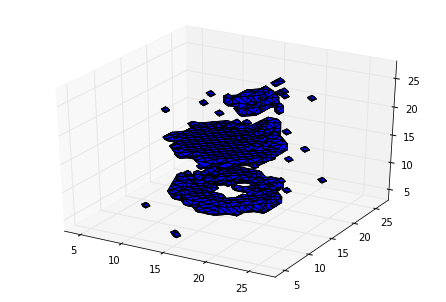

generated model at step 30


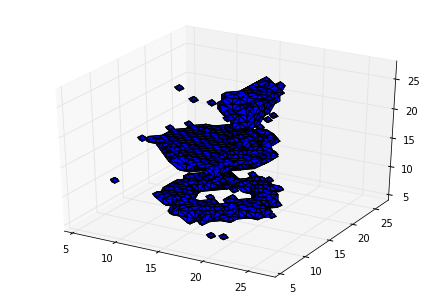

generated model at step 35


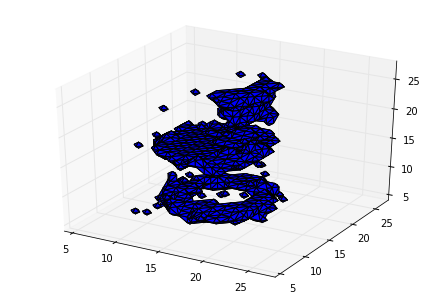

generated model at step 40


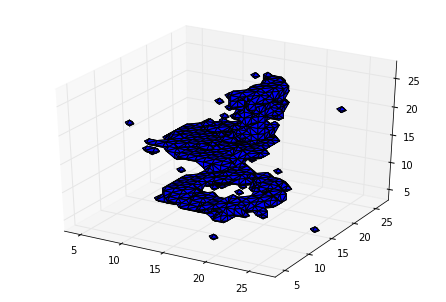

generated model at step 50


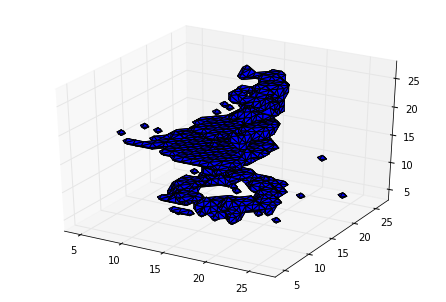

generated model at step 60


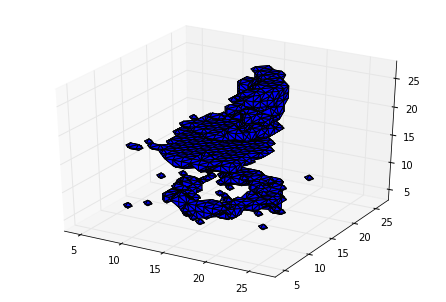

In [1035]:
### create a single random instance
z1 = np.zeros(32*32*32)
# the percentage of z1 to be 1, rest is 0
# 0.013: small chair
# 0.0125: small stool, hovering saucer
density = 0.0135

# randomly select density% elems to be 1
index = range(z1.shape[0])
random_generator = np.random.RandomState(1)
random_generator.shuffle(index)
selected_indices = index[:int(np.floor(z1.shape[0]*density))] 
z1[selected_indices] = 1


step = 0
while step < 61:
    
    voxel_matrix = z1.reshape([32,32,32]) 
    
    # plot voxel models at every n step
    if step in [0,1,2,3,4,5,7,9,12,15,20,25,30,35,40,50,60]:
        print 'generated model at step', step
        plot_3d(voxel_matrix)
    
        '''
        # save voxel models at every n step
        vertices, faces = measure.marching_cubes(voxel_matrix,level=0.5)

        # Create the mesh and save as STL
        obj = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
        for i, f in enumerate(faces):
            for j in range(3):
                obj.vectors[i][j] = vertices[f[j],:]

        # Write the mesh to STL file 
        obj.save('generated_'+str(step)+'.stl')
        '''
    # perform gibbs sampling
    gibbs_x = rbm.gibbs(z1) # return T/F which original pixels are activated
    z1 = np.zeros_like(z1)
    z1[gibbs_x] = 1 # make the "turned on" pixels to be 1, others to be 0
    
    step+=1

#### See what happens if we generate using a person model

generated model at step 0


/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


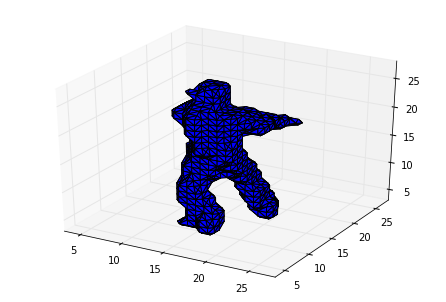

generated model at step 1


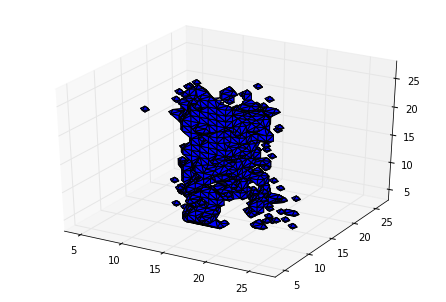

generated model at step 2


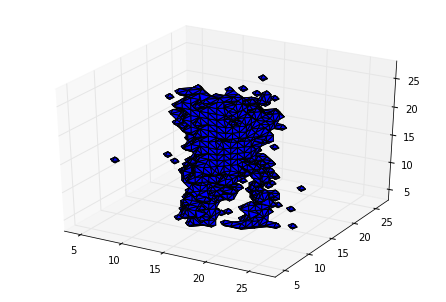

generated model at step 3


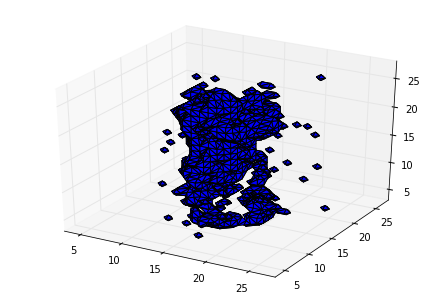

generated model at step 4


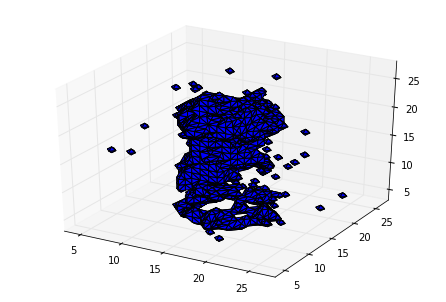

generated model at step 5


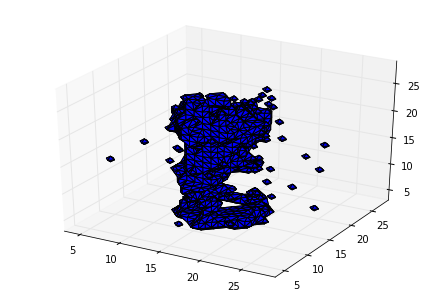

generated model at step 7


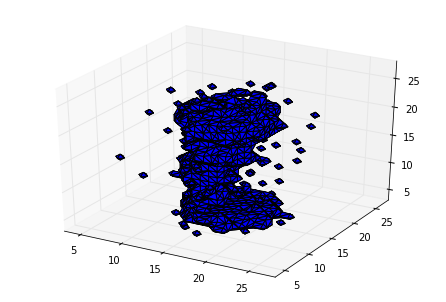

generated model at step 9


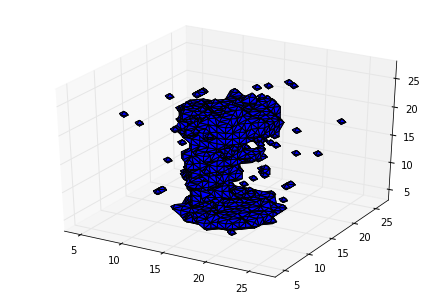

generated model at step 12


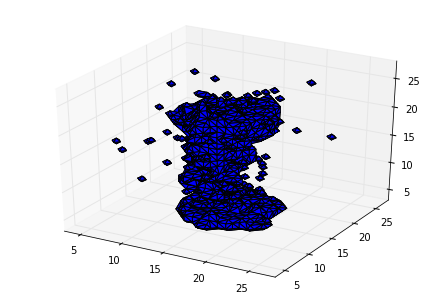

generated model at step 15


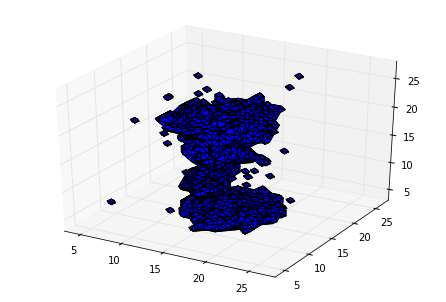

generated model at step 20


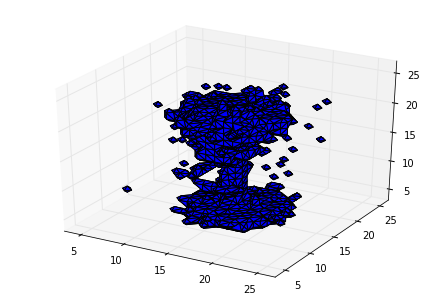

generated model at step 25


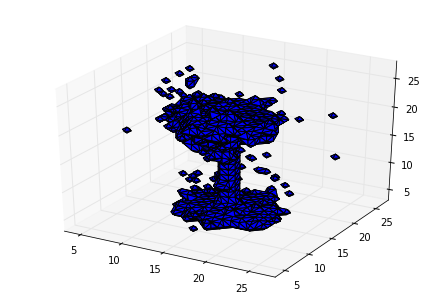

generated model at step 30


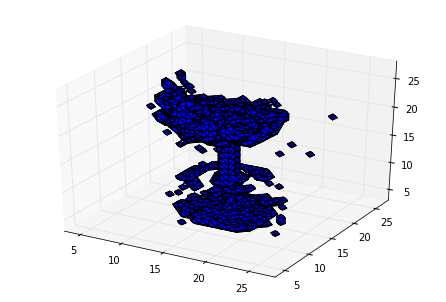

generated model at step 35


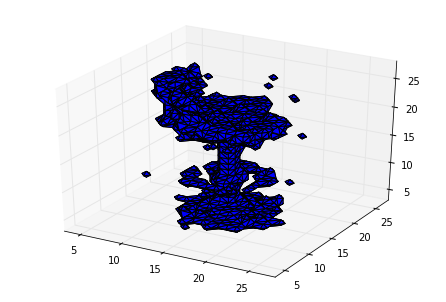

generated model at step 40


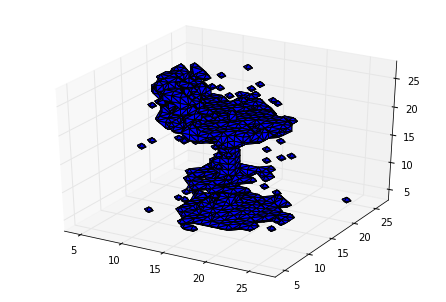

generated model at step 50


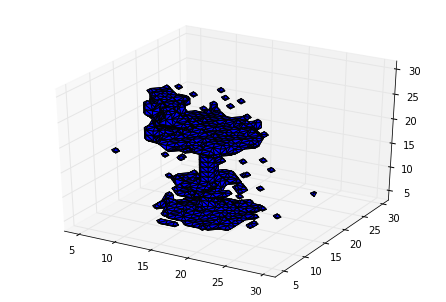

generated model at step 60


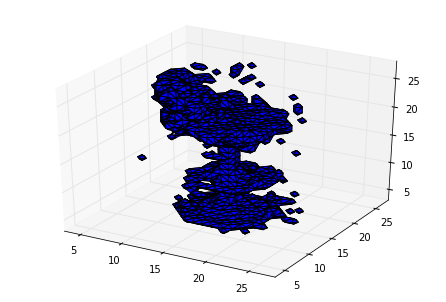

In [1261]:
person = np.load('/Users/yuxuanzhang/CSC529/3D_voxel_models/person/person_000000046_5')
person = person.reshape([1,32*32*32]) 

step = 0
while step < 61:
    
    voxel_matrix = person.reshape([32,32,32]) 
    
    # plot voxel models at every n step
    if step in [0,1,2,3,4,5,7,9,12,15,20,25,30,35,40,50,60]:
        print 'generated model at step', step
        plot_3d(voxel_matrix)

    # perform gibbs sampling
    gibbs_x = rbm.gibbs(person) # return T/F which original pixels are activated
    person = np.zeros_like(person)
    person[gibbs_x] = 1 # make the "turned on" pixels to be 1, others to be 0
    
    step+=1